- Code adapted from documentation: https://www.tensorflow.org/beta/tutorials/generative/dcgan

# Step 1: Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import tensorflow as tf

# Step 2: Importing and processing the database

In [2]:
(train_images, train_labels), (_,_) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
train_images.shape

(60000, 28, 28)

In [5]:
train_labels.shape

(60000,)

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [7]:
train_images.shape

(60000, 28, 28, 1)

In [8]:
train_images = (train_images - 127.5)/127.5

In [9]:
buffer_size = 60000
batch_size = 256

In [44]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [45]:
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Step 3: Data Visualization

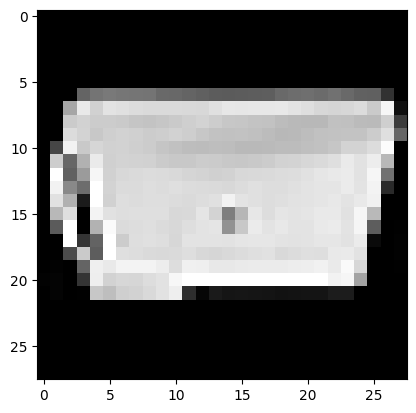

In [14]:
plt.imshow(train_images[110].reshape((28,28)), cmap = 'gray');

# Step 4: Generator Construction

In [20]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias = False, input_shape = (100,))) # 12544
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))

  #7x7x128

  model.add(layers.Conv2DTranspose(128, (5,5), strides = (1,1), padding = 'same', use_bias = False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  #14x14x64
  model.add(layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding = 'same', use_bias = False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  #28x28x1
  model.add(layers.Conv2DTranspose(1, (5,5), strides = (2,2), padding = 'same', use_bias = False, activation = 'tanh'))

  model.summary()

  return model




In [16]:
noise = tf.random.normal([1,100])

In [21]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.74972934, -1.0306791 , -0.9943087 ,  0.14282085,  0.8443118 ,
         0.49196684, -0.9583029 ,  0.5447005 ,  0.8111471 ,  1.70074   ,
         0.53652906,  1.271802  , -0.05639861, -1.0077275 , -0.16975054,
         0.62157834,  0.6614665 ,  0.8917265 ,  1.0447131 , -1.5617379 ,
        -0.8234191 ,  2.0858078 , -1.0113547 , -0.3411763 ,  1.3189596 ,
         0.8430796 ,  0.860043  ,  0.84921056, -0.618764  , -1.6697458 ,
         0.69728446,  1.5351593 ,  0.28317362, -1.6807089 ,  1.2931501 ,
         0.43213886,  1.115874  ,  0.6397128 ,  0.01632693,  1.2411959 ,
        -0.5716564 , -0.9412275 , -0.2288098 , -0.57569605, -0.79999745,
        -1.4178157 , -0.02088767,  0.9702964 ,  2.4872088 , -0.40988138,
        -0.56698257,  0.23449162, -1.559139  , -1.0566585 ,  0.8905837 ,
        -0.6231234 , -3.3585465 ,  0.26192266,  1.5293279 , -0.1645071 ,
         0.39065152,  0.87494826, -1.5646634 ,  0.89675534, -0.56237924,
 

In [22]:
generator = make_generator_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [23]:
generated_image = generator(noise, training = False)

In [25]:
generated_image.shape

TensorShape([1, 28, 28, 1])

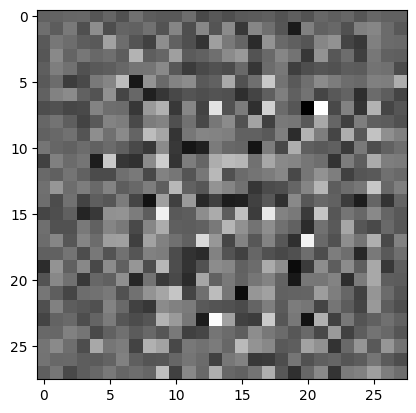

In [27]:
plt.imshow(generated_image[0,:,:,0], cmap = 'gray')

# Step 5: Construction of the discriminator

In [28]:
def make_discriminator_model():
  model = tf.keras.Sequential()

  #14x14x64
  model.add(layers.Conv2D(64, (5,5), strides = (2,2), padding = 'same', input_shape = [28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  #7x7x128
  model.add(layers.Conv2D(128, (5,5), strides = (5,5), padding = 'same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  #7x7x128 = 6272
  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  model.summary()

  return model

In [29]:
discriminator = make_discriminator_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 3, 3, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 128)         0         
                                                                 
 flatten (Flatten)           (None, 1152)             

In [30]:
decision = discriminator(generated_image, training = False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.0002215]], dtype=float32)>

# Step 6: Loss function for both networks

In [33]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [55]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss

  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)


In [35]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

In [36]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

#Step 7: Model Training

In [38]:
epochs = 100
noise_dim = 100
num_examples_to_generate = 16

In [39]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [57]:
@tf.function
def train_steps(images):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Chamar o gerador e passar os números aleatórios
    generated_images = generator(noise, training = True)
    # Passar para o discriminador as imagens reais e falsas para fazer a classificação

    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    # Calcular a loss para o gerador e discriminador

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  # Calcular o gradiente das losses para atualizar os pesos
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # Aplicar os otimizadores e atualizar os pesos
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [59]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in  dataset:
      train_steps(image_batch)

    display.clear_output(wait = True)
    generate_and_save_images(generator, epoch + 1, seed )

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    display.clear_output(wait = True)
    generate_and_save_images(generator, epoch + 1, seed )

In [48]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training = False)

  fig = plt.figure(figsize = (4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4, i + 1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 +127.5, cmap = 'gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_`{:04d}.png'.format(epoch))
  plt.show()

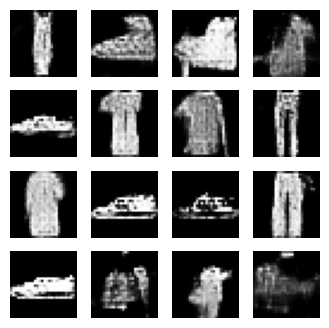

In [ ]:
train(train_dataset, epochs)